<a href="https://colab.research.google.com/github/Naina-j04/Atri-Assignment/blob/main/Predictions_of_Garbage_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from PIL import Image
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#pointing to dataset
data_dir  = '/content/drive/MyDrive/Garbage_classification/Data'

classes = os.listdir(data_dir)
print(classes)

['plastic', 'trash', 'paper', 'glass', 'metal', 'cardboard', 'garbage.pth', 'bettermodel.pth', 'bettermodel2.pth', 'model_resnet2.pth', 'model_resnet3.pth', 'model_resnet1.pth', 'model1.pth', 'model2.pth']


In [4]:
#resizing and normalizing the dataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])

dataset = ImageFolder(data_dir, transform = transformations)

In [5]:
len(dataset)


2527

In [6]:
#splitting the dataset
train_data,val_data,test_data=random_split(dataset,[1616,405,506])
len(train_data),len(val_data),len(test_data)

(1616, 405, 506)

In [7]:
#checking how many images from each class split b/w TVT
train_idx = train_data.indices
val_idx   = val_data.indices
test_idx  = test_data.indices

print("Train class counts:", Counter([dataset.targets[i] for i in train_idx]))
print("Val class counts:", Counter([dataset.targets[i] for i in val_idx]))
print("Test class counts:", Counter([dataset.targets[i] for i in test_idx]))


Train class counts: Counter({3: 381, 1: 319, 4: 303, 2: 265, 0: 255, 5: 93})
Val class counts: Counter({3: 98, 1: 86, 4: 72, 2: 65, 0: 62, 5: 22})
Test class counts: Counter({3: 115, 4: 107, 1: 96, 0: 86, 2: 80, 5: 22})


In [19]:
model = models.resnet50(weights='DEFAULT')

# freezing the pre-trained layers
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# replace the final fully connected layer for the 6 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [20]:
#dataloader
train_loader=DataLoader(train_data,batch_size=32,shuffle=True)
val_loader=DataLoader(val_data,batch_size=32,shuffle=False)
test_loader=DataLoader(test_data,batch_size=32,shuffle=False)

In [23]:
#defining the training components
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(([
    {'params': model.layer3.parameters(), 'lr': 1e-5},
    {'params': model.layer4.parameters(), 'lr': 1e-4},
    {'params': model.fc.parameters(), 'lr': 1e-3},
]))
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
device
print(model.fc)


Linear(in_features=2048, out_features=6, bias=True)


In [25]:
num_epochs = 30
print("Starting Training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    accuracy = 100 * correct / total

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {accuracy:.2f}%')
    scheduler.step(val_loss)
print('Finished Training.')


Starting Training...
Epoch [1/30], Training Loss: 0.5111, Validation Loss: 0.5109, Validation Accuracy: 80.74%
Epoch [2/30], Training Loss: 0.3061, Validation Loss: 0.4233, Validation Accuracy: 84.94%
Epoch [3/30], Training Loss: 0.2057, Validation Loss: 0.5182, Validation Accuracy: 83.95%
Epoch [4/30], Training Loss: 0.1367, Validation Loss: 0.4374, Validation Accuracy: 86.67%
Epoch [5/30], Training Loss: 0.0889, Validation Loss: 0.4800, Validation Accuracy: 85.68%
Epoch [6/30], Training Loss: 0.0764, Validation Loss: 0.5085, Validation Accuracy: 85.68%
Epoch [7/30], Training Loss: 0.0574, Validation Loss: 0.4529, Validation Accuracy: 87.16%
Epoch [8/30], Training Loss: 0.0549, Validation Loss: 0.4180, Validation Accuracy: 88.89%
Epoch [9/30], Training Loss: 0.0571, Validation Loss: 0.4419, Validation Accuracy: 87.90%
Epoch [10/30], Training Loss: 0.0362, Validation Loss: 0.4434, Validation Accuracy: 86.91%
Epoch [11/30], Training Loss: 0.0458, Validation Loss: 0.4309, Validation Accu

In [26]:
# FINAL TEST EVALUATION
print('Starting Final Evaluation on Test Set...')
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_loss += criterion(outputs, labels).item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
accuracy = 100 * correct / total
print(f'Final Test Loss: {avg_test_loss:.4f}, Final Test Accuracy: {accuracy:.2f}%')

Starting Final Evaluation on Test Set...
Final Test Loss: 0.3560, Final Test Accuracy: 89.33%


In [27]:
print(model.fc)
path='/content/drive/MyDrive/Garbage_classification/Data/imagemodel.pth'
torch.save(model.state_dict(), path)

Linear(in_features=2048, out_features=6, bias=True)


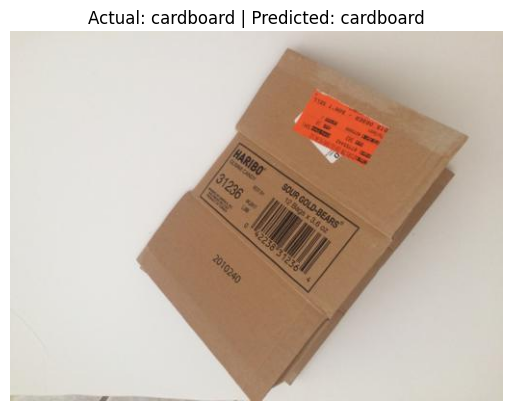

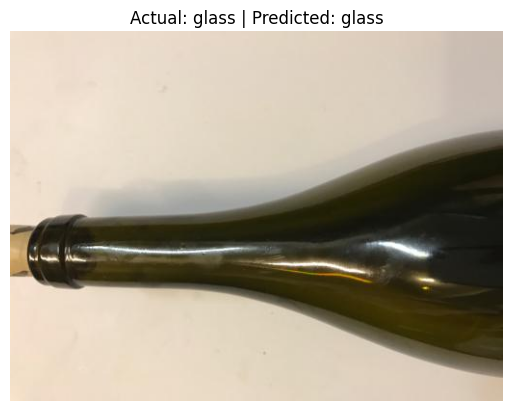

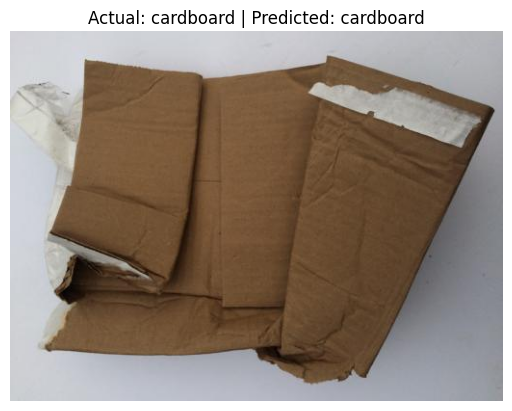

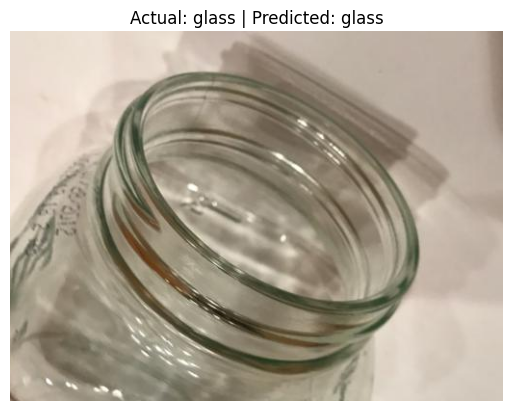

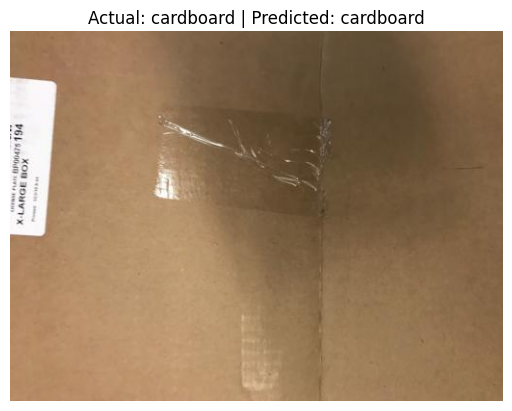

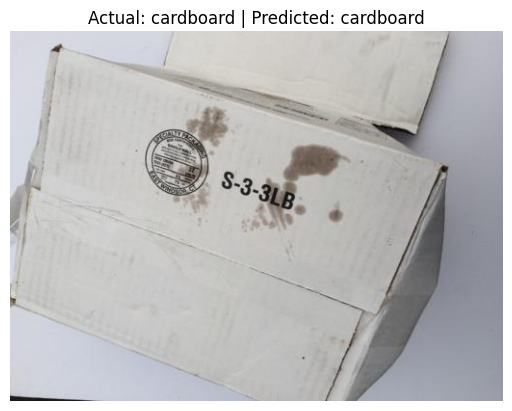

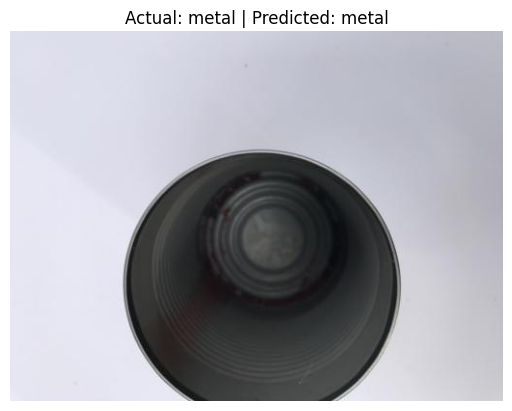

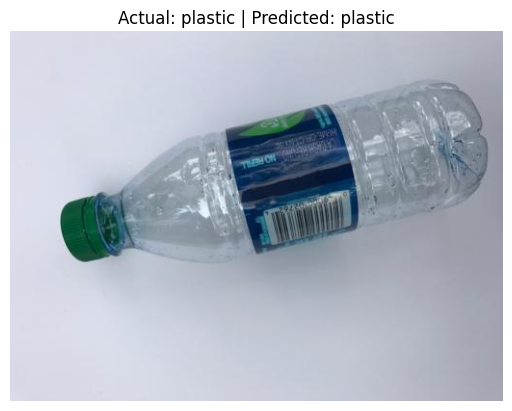

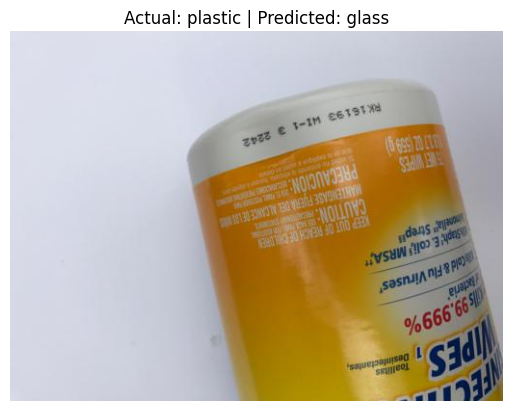

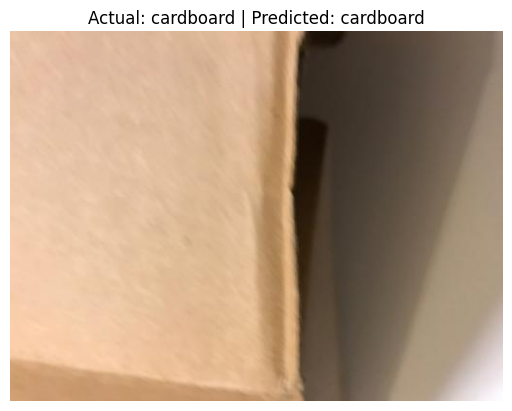

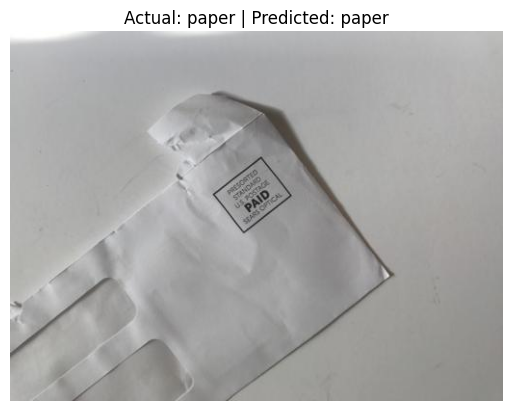

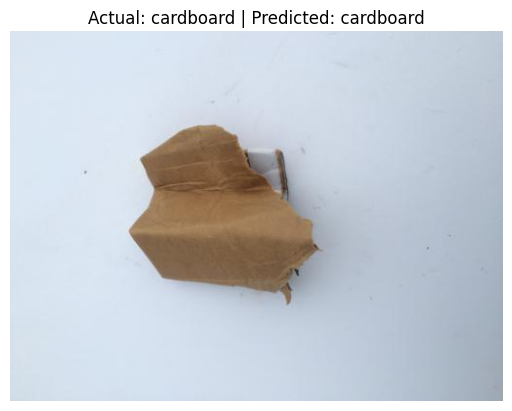

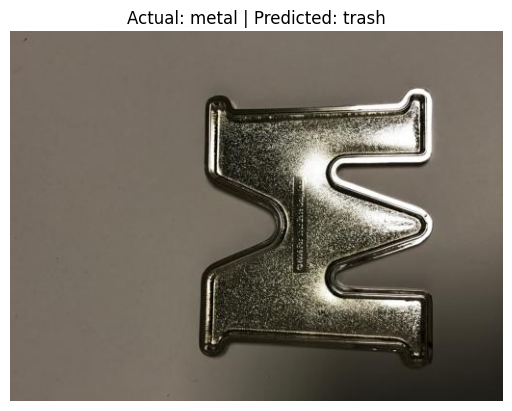

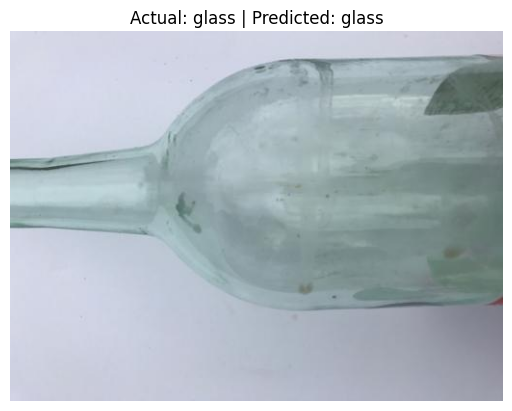

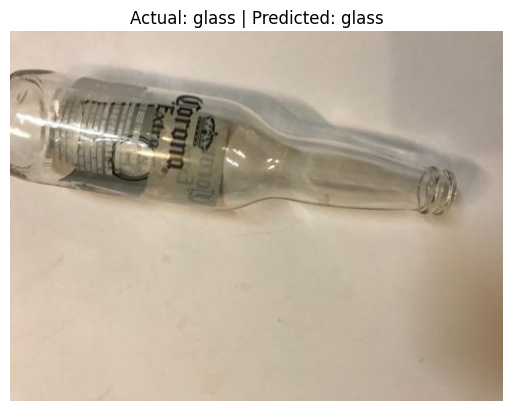

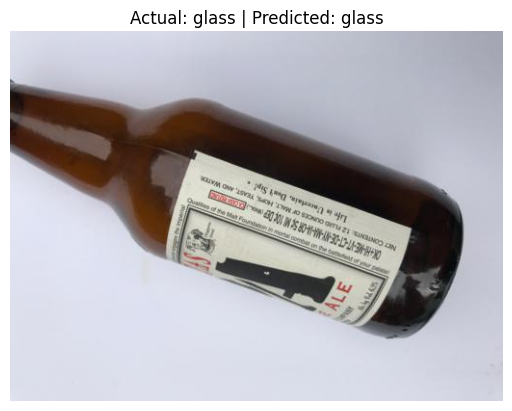

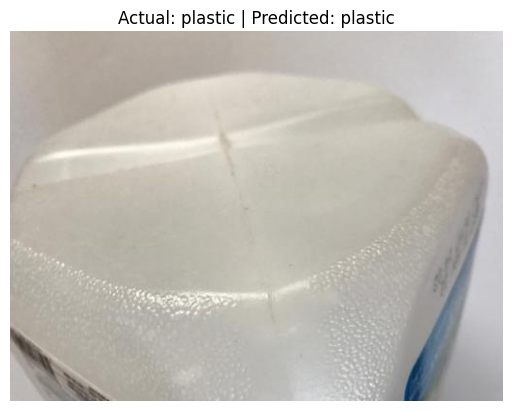

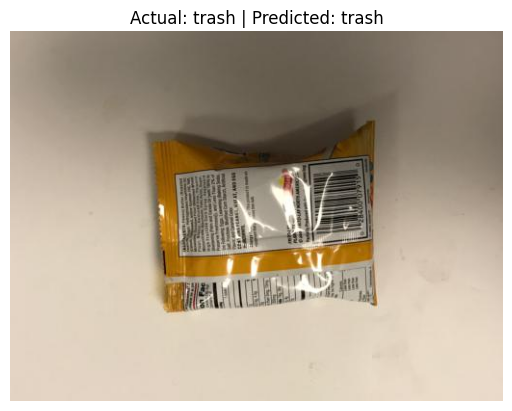

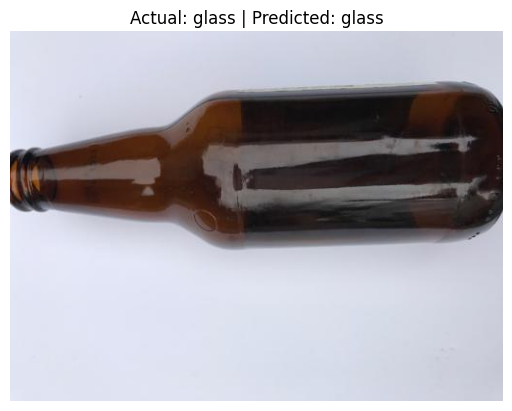

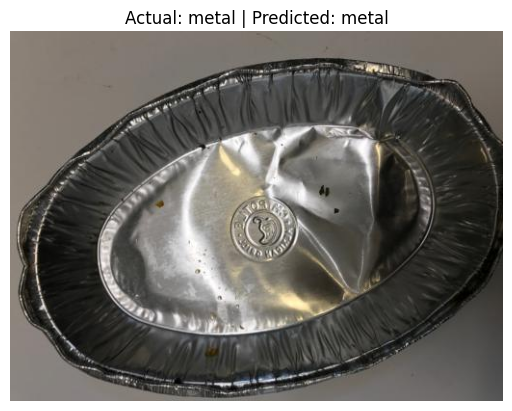

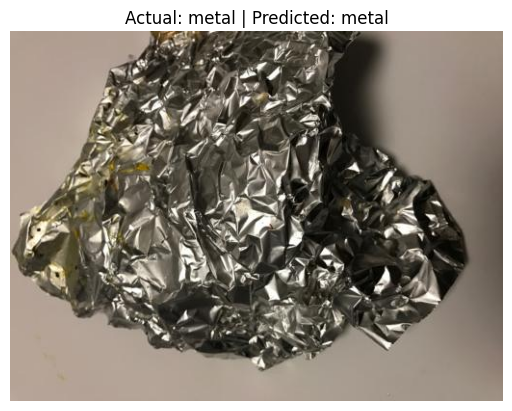

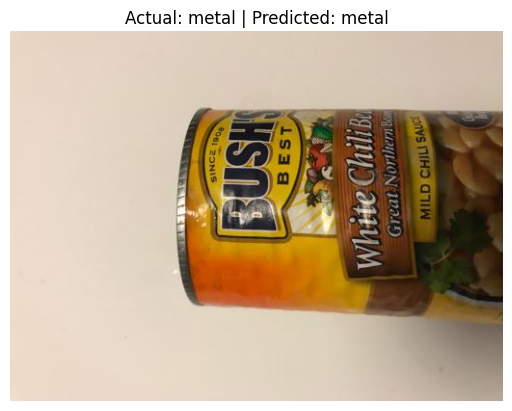

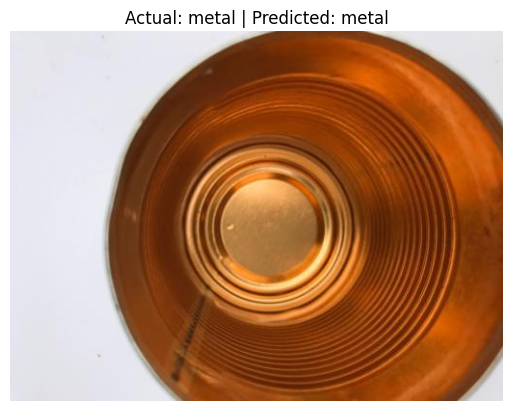

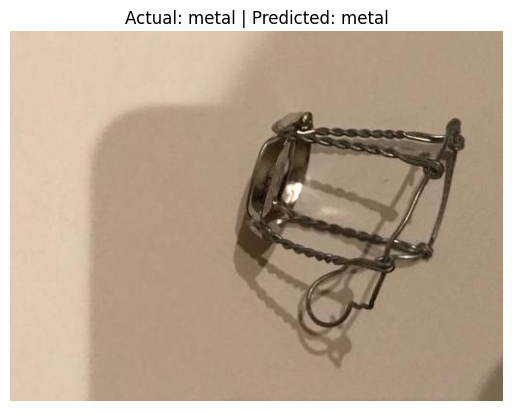

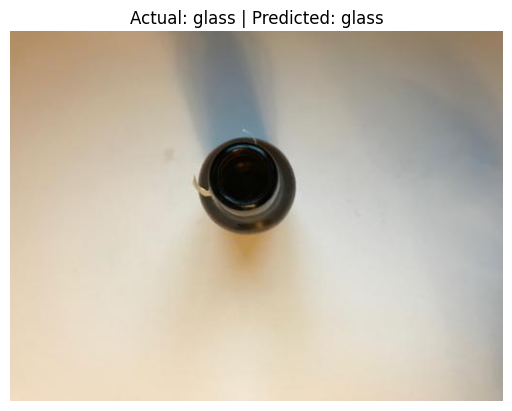

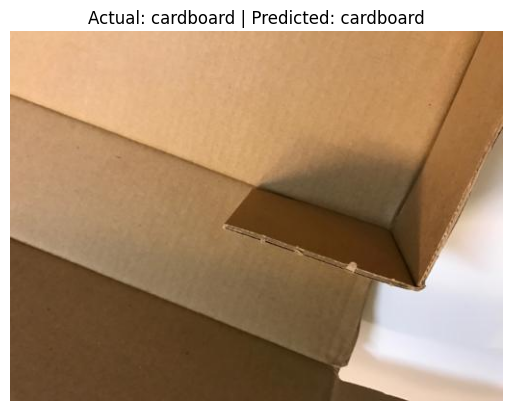

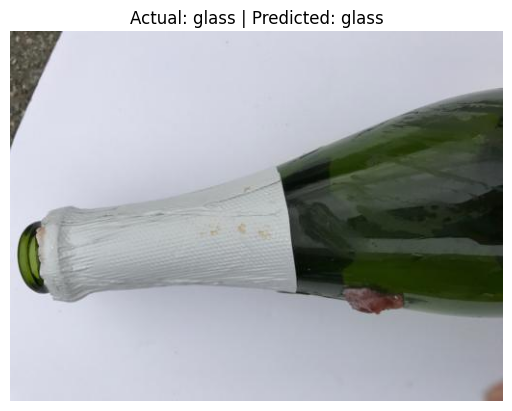

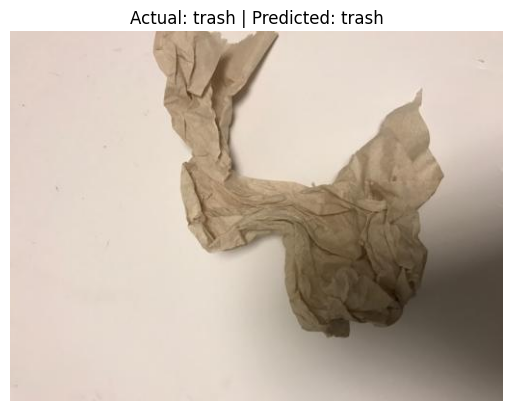

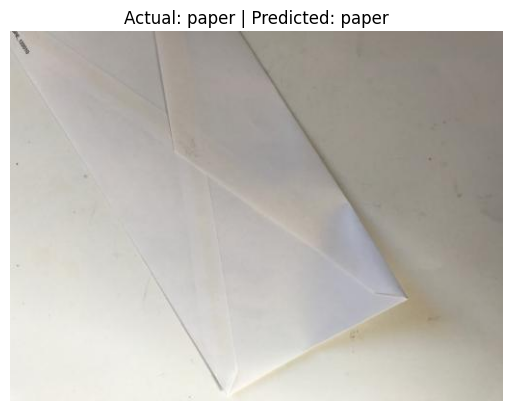

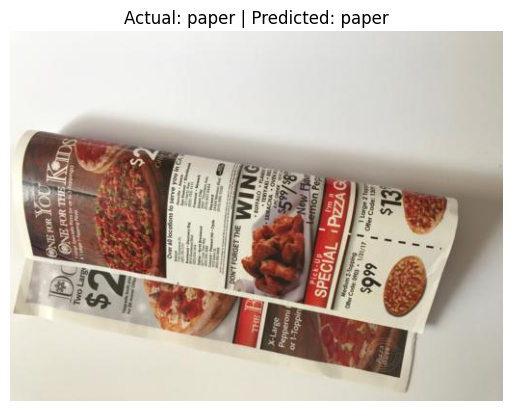

In [44]:
model = models.resnet50(weights='DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)  # 6 classes
path = '/content/drive/MyDrive/Garbage_classification/Data/imagemodel.pth'
model.load_state_dict(torch.load(path))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def predict_image(image_path):
    # Preprocessing prediction images
    transformations = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    # Loading images
    image = Image.open(image_path).convert('RGB')
    image_tensor = transformations(image).unsqueeze(0).to(device)
    class_names = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]
    # Prediction time
    with torch.no_grad():
        output = model(image_tensor)
    _, predicted_idx = torch.max(output, 1)
    predicted_class = class_names[predicted_idx.item()]
    actual_class = image_path.split('/')[-2]
    plt.imshow(image)
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    return predicted_class

# Eg multiple images
root = '/content/drive/MyDrive/Garbage_classification/Data'
images = []

# Loop through all folders (classes)
for class_folder in os.listdir(root):
    folder_path = os.path.join(root, class_folder)
    if os.path.isdir(folder_path):
        # Collect all image paths
        image_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png'))]
        images.extend(image_files)

# Randomly select 10 images
random_images = random.sample(images, 30)
for img_path in random_images:
    result = predict_image(img_path)



In [40]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


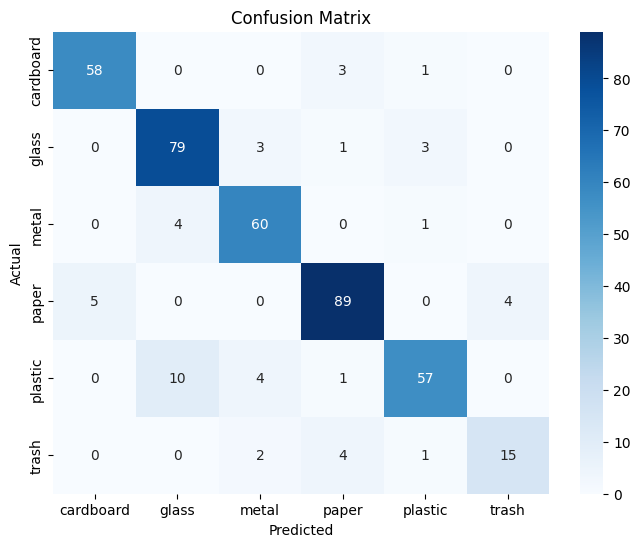

In [41]:
cm = confusion_matrix(all_labels, all_preds)
class_names = dataset.classes  # ['cardboard','glass','metal','paper','plastic','trash']

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [46]:
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

   cardboard       0.92      0.94      0.93        62
       glass       0.85      0.92      0.88        86
       metal       0.87      0.92      0.90        65
       paper       0.91      0.91      0.91        98
     plastic       0.90      0.79      0.84        72
       trash       0.79      0.68      0.73        22

    accuracy                           0.88       405
   macro avg       0.87      0.86      0.87       405
weighted avg       0.88      0.88      0.88       405

